# Ingredient Image Analysis

The focus of this analysis lies on the OpenFoodFacts products which have associated ingredient images.

Data used: jsonl.gz dataset from March 17 2025.

## Insights Summary

1,017,429 products have ingredient image(s) - which is ~27.7% of all products

### Tags assigned to products

Products have state_tags and data_quality_tags that usually correlate with other fields. However, they not fully aligned.

- 961,041 products with ingredient image(s) (94.5%) have state tag `en:ingredients-photo-selected` -> 56,398 (5.5%) missing. 🤔
- 639,044 products with ingredient image(s) (62.2%) have identified ingredients (known, unknown) -> 378,385 products (37.7%) have not been analyzed. 🤔
- 639,133 products (62.3%) have field `ingredients_percent_analysis`
- 568,873 products (55.5%) have `ingredients_percent_analysis` = 1
- 568,282 products (??) have data_quality_tag `en:ingredients-percent-analysis-ok`

### Number of ingredient images per product

- 895,262 products (88.0%) have one ingredient image.
- 108,168 products (10.6%) have two ingredient images.
-  14,009 products ( 1.4%) have three or more ingredient images.

### Languages of ingredient images

- 579,762 (57.0%) fr 🇫🇷
- 212,462 (20.9%) en 🇬🇧🇺🇸
- 107,551 (10.6%) de 🇩🇪
-  78,250 ( 7.7%) es 🇪🇸
-  46,234 ( 4.5%) no lc ❓🤔
- 139,042 (13.7%) in 111 other languages 🌎

### Open Questions:
- OCR
    - how many photos have extracted text?
    - are extractions missing for some languages?
    - what is the reported extraction error from Google Vision?
- Ingredient Recognition
    - What are the most unrecognized ingredients per image?
    - What is the main reason for these errors? (OCR, spelling, missing taxonomy?)

## Download jsonl.gz snapshot

This will take a couple of minutes

In [1]:
%%time
%%bash
if [ ! -f "openfoodfacts-products.jsonl.gz" ]; then
    curl -L -O https://static.openfoodfacts.org/data/openfoodfacts-products.jsonl.gz;
else
    echo "file already exists. skipping download";
fi

file already exists. skipping download
CPU times: user 2.43 ms, sys: 6.23 ms, total: 8.66 ms
Wall time: 8.19 ms


## Data Extraction

Extract relevant fields related to ingredients and ingredient images.

This is done with `jq` which is well suited for processing json data. An alternative is duckdb - it is faster but has issues, like unexpected characters and duplicates when dealing with gz files.

This can take 15-20 minutes.

In [2]:
%%time
%%bash
if [ ! -f "ingredients_data_export_jq.csv.gz" ]; then
  (
  echo "code,ingredients_n,known_ingredients_n,unknown_ingredients_n,has_analysis_tags,ingredients_percent_analysis,ingredients_text,images,states,quality_info"
  zcat < openfoodfacts-products.jsonl.gz | jq -r '
  (.images // {}) as $img |
  ($img | to_entries | map(select(.key | startswith("ingred"))) ) as $ingimg |
  def resolve(field):
    if .value.imgid == null then null else $img[ (.value.imgid | tostring) ][field] end;
  def subset(prefix):
    map(select(startswith(prefix))) | if length > 0 then join(",") else null end;
  [
    .code,
    (if .ingredients_n == null then null else (.ingredients_n | tonumber) end),
    (if .known_ingredients_n == null then null else (.known_ingredients_n | tonumber) end),
    (if .unknown_ingredients_n == null then null else (.unknown_ingredients_n | tonumber) end),
    (if .ingredients_analysis_tags != null then true else false end),
    .ingredients_percent_analysis,
    .ingredients_text,
    ($ingimg
      | map({ key: .key, value: { imgid: .value.imgid, uploader: resolve("uploader"), uploaded_t: resolve("uploaded_t") } })
      | from_entries
      | if length > 0 then tojson else null end
    ),
    (.states_tags // [] | subset("en:ingred")),
    (.data_quality_info_tags // [] | subset("en:ingred"))
  ]
  | @csv'
  ) | gzip -9 >ingredients_data_export_jq.csv.gz
else
  echo "file already exists. skipping processing";
fi

file already exists. skipping processing
CPU times: user 1.66 ms, sys: 5.07 ms, total: 6.73 ms
Wall time: 6.63 ms


## Data Loading

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import colorsys
from matplotlib.ticker import FuncFormatter
from dateutil.relativedelta import relativedelta

In [4]:
%%time
file_path = "./ingredients_data_export_jq.csv.gz"
df = pd.read_csv(file_path, dtype={'code':str})
df = df[df.code.notna()].set_index('code') # exclude empty barcodes

# use Int64 for counts with NaN
for col in ['ingredients_n', 'known_ingredients_n', 'unknown_ingredients_n', 'ingredients_percent_analysis']:
    df[col] = df[col].astype('Int64')

# convert json string to dict
df.images = df.images.fillna('null').map(json.loads)

display(df)

,ingredients_n,known_ingredients_n,unknown_ingredients_n,has_analysis_tags,ingredients_percent_analysis,ingredients_text,images,states,quality_info
code,,,,,,,,,
0000101209159,<NA>,<NA>,<NA>,False,<NA>,NaN,"{'ingredients_fr': {'imgid': '2', 'uploader': ...","en:ingredients-to-be-completed,en:ingredients-...",NaN
0000105000011,1,3,0,True,1,CHAMOMILE FLOWERS.,None,en:ingredients-completed,en:ingredients-percent-analysis-ok
0000105000042,1,3,0,True,1,Peppermint.,None,en:ingredients-completed,en:ingredients-percent-analysis-ok
0000105000059,1,0,1,True,1,LINDEN FLOWERS.,None,en:ingredients-completed,en:ingredients-percent-analysis-ok
0000105000073,1,2,0,True,1,Hibiscus flowers.,None,en:ingredients-completed,en:ingredients-percent-analysis-ok
...,...,...,...,...,...,...,...,...,...
8718907242424,<NA>,<NA>,<NA>,False,<NA>,NaN,None,en:ingredients-to-be-completed,NaN
0007405956277,<NA>,<NA>,<NA>,False,<NA>,NaN,None,"en:ingredients-to-be-completed,en:ingredients-...",NaN
3760019590615,<NA>,<NA>,<NA>,False,<NA>,NaN,None,"en:ingredients-to-be-completed,en:ingredients-...",NaN


CPU times: user 12.3 s, sys: 1.06 s, total: 13.3 s
Wall time: 13.7 s


### Check Duplicate Barcodes

Unfortunately, the dataset contains some duplicate barcodes. However, it is not real duplicates because the data differs and seems to be from separate updates/edits.

This would need further investigation but is ignored right now.

In [5]:
df.loc[lambda x: x.index.value_counts() > 1].sort_index()

,ingredients_n,known_ingredients_n,unknown_ingredients_n,has_analysis_tags,ingredients_percent_analysis,ingredients_text,images,states,quality_info
code,,,,,,,,,
0059527070430,24,34,4,True,-1,"Raisins* (20%) (raisins*, huile de tournesol*)...","{'ingredients_fr': {'imgid': '4', 'uploader': ...","en:ingredients-completed,en:ingredients-photo-...",NaN
0059527070430,21,36,0,True,1,"Raisins secs*(20%)(raisins secs*, huile de tou...","{'ingredients_fr': {'imgid': '3', 'uploader': ...","en:ingredients-completed,en:ingredients-photo-...",en:ingredients-percent-analysis-ok
0059527171687,24,28,6,True,-1,"CASHEWS (14%) AGAVE SYRUP*, ROASTED PEANUTS* (...","{'ingredients_en': {'imgid': '1', 'uploader': ...","en:ingredients-completed,en:ingredients-photo-...",NaN
0059527171687,24,40,1,True,1,"Noix de cajou* (15%), sirop d’agave*, arachide...","{'ingredients_fr': {'imgid': '4', 'uploader': ...","en:ingredients-completed,en:ingredients-photo-...",en:ingredients-percent-analysis-ok
0059527401555,<NA>,<NA>,<NA>,False,<NA>,NaN,"{'ingredients_fr': {'imgid': '5', 'uploader': ...","en:ingredients-to-be-completed,en:ingredients-...",NaN
...,...,...,...,...,...,...,...,...,...
8722700628927,13,21,2,True,1,Gelato alla panna. Ingredienti: LATTE Scremato...,"{'ingredients_it': {'imgid': '1', 'uploader': ...","en:ingredients-completed,en:ingredients-photo-...",en:ingredients-percent-analysis-ok
915024285012997,<NA>,<NA>,<NA>,False,<NA>,NaN,None,"en:ingredients-to-be-completed,en:ingredients-...",NaN
915024285012997,<NA>,<NA>,<NA>,False,<NA>,NaN,None,"en:ingredients-to-be-completed,en:ingredients-...",NaN


In [6]:
# helper functions for charts

# Annotate each horizontal bar with its value
def annotate_hbars(ax, total: int):
    for bar in ax.patches:
        width = bar.get_width()
        ax.text(width + 1, bar.get_y() + bar.get_height() / 2,
            f' {width:,}\n ({width / total * 100:.1f}%)', va='center', ha='left', fontsize=8)

# Annotate each vertical bar with its value
def annotate_vbars(ax, total: int):
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height / 1000:.1f}k\n{height / total * 100:.1f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=6)

# Annotate the cells of a matrix/heatmap
def annotate_matrix(ax, df_cross: pd.DataFrame, max_x: int, max_y:int, total: int):
  for y in range(max_y):
      for x in range(max_x):
          # The co-occurrence value at row i, column j
          value = df_cross.iloc[y, x]
          ax.text(x, y, f"{value:,}\n{value / total * 100:.1f}%",
                  ha='center', va='center', color='white', fontsize=7)

# color adjustment helper
def adjust_color(color, factor):
    """
    Adjust the brightness of a color.
    factor: multiplier for brigthness (e.g., between 0.5 and 1.0).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    new_l = max(0, min(1, l * factor))
    return mcolors.to_rgb(colorsys.hls_to_rgb(h, new_l, s))

# cell-color function.
def get_cell_color(row, col, value, vmin, vmax):
    # Determine a base color based on row and column indices.
    if row == 0 and col == 0:
        base = "green"
    elif row < 2 and col < 2:
        base = "limegreen"
    elif row < 3 and col < 3:
        base = "orange"
    elif row < 4 and col < 4:
        base = "red"
    elif row < 5 and col < 5:
        base = "brown"
    else:
        base = "grey"
    
    # higher values should be brighter, normalize the value over the DataFrame's range.
    factor = 0.3 + 0.7 * ((value - vmin) / (vmax - vmin))
    # Adjust the base color.
    # mcolors.to_rgba expects a color spec; we convert the adjusted color back to a hex code.
    adjusted_rgb = adjust_color(base, factor)
    # Convert the RGB tuple to an RGBA tuple with alpha=1.
    return (adjusted_rgb[0], adjusted_rgb[1], adjusted_rgb[2], 1.0)

## Part I: Analyze Ingredient Images

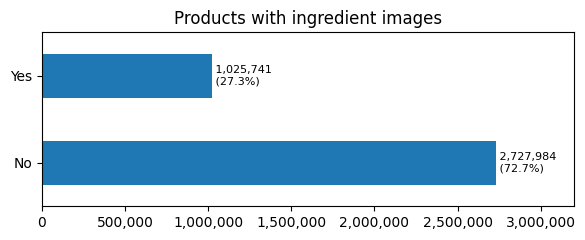

In [7]:
has_image = df.images.notna()
ax = has_image.value_counts().plot.barh(figsize=(6,2.5))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.set_ylabel(None)
ax.set_yticklabels(['No', 'Yes'])

annotate_hbars(ax, len(df))
plt.xlim(0, 3.2e6)

plt.title('Products with ingredient images')
plt.tight_layout()
plt.show()

In [8]:
# create subset of products with images
df_images = df[has_image]

## Check coverage of `en:ingredients-photo-selected`

The states tag `en:ingredients-photo-selected` should get set when an ingredient images is selected. Let's see if this correlates with what we find in the images object.

-> There are actually 57k product with ingredient images missing this tag.

In [9]:
print("selected total:", df.states.str.contains('en:ingredients-photo-selected').sum())
print("selected images:", df_images.states.str.contains('en:ingredients-photo-selected').sum())
print("images total:", len(df_images))
print("selected images diff:", "{:,}".format(len(df_images) - df.states.str.contains('en:ingredients-photo-selected').sum()))
print("selected images percent:", "{:.1f}%".format(df.states.str.contains('en:ingredients-photo-selected').sum() / len(df_images) * 100))

selected total: 968681
selected images: 968681
images total: 1025741
selected images diff: 57,060
selected images percent: 94.4%


## Number of Ingredient Images per Product

Ingredient images can be selected for multiple languages. Let's check the distribution.

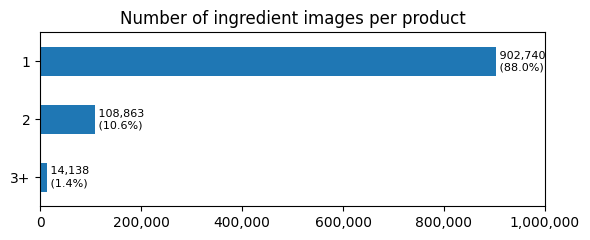

In [10]:
img_counts = df_images.images.map(len).map(lambda x: "3+" if x >= 3 else str(x))

ax = img_counts.value_counts().sort_index(ascending=False).plot.barh(figsize=(6,2.5))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.set_ylabel(None)
ax.set_xlim(0, 1e6)

annotate_hbars(ax, len(df_images))
    
plt.title('Number of ingredient images per product')
plt.tight_layout()
plt.show()

### What are the most frequent languages of ingredient images?

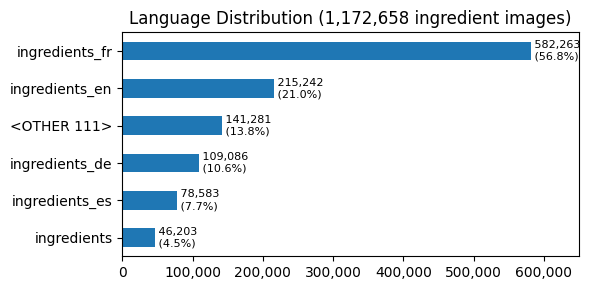

In [11]:
max_count = 5
img_lang = df_images.images.map(dict.keys).explode()
top_langs = img_lang.value_counts().head(max_count).index
other_count= len(img_lang.value_counts())-max_count
lang_values = img_lang.map(lambda x: x if x in top_langs else f"<OTHER {other_count}>").value_counts()

ax = lang_values.plot.barh(figsize=(6,3))
ax.invert_yaxis()

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.set_ylabel(None)
ax.set_xlim(0, 650000)

annotate_hbars(ax, len(df_images))
    
plt.title(f'Language Distribution ({len(img_lang):,} ingredient images)')
plt.tight_layout()
plt.show()

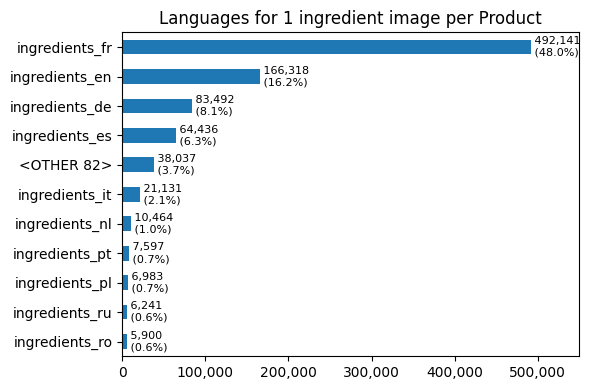

In [12]:
img_lang1 = df_images.images[img_counts == '1'].map(dict.keys).explode()
top_langs1 = img_lang1.value_counts().head(10).index
other_count= len(img_lang1.value_counts())-10

ax = img_lang1.map(lambda x: x if x in top_langs1 else f"<OTHER {other_count}>").value_counts().plot.barh(figsize=(6,4))
ax.invert_yaxis()

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.set_ylabel(None)
ax.set_xlim(0, 550000)

annotate_hbars(ax, len(df_images))

plt.title('Languages for 1 ingredient image per Product', )
plt.tight_layout()
plt.show()

### Language Co-occurrence

In [13]:
dummies = pd.get_dummies(df_images.images[lambda x: x.map(len) > 1].explode()).groupby(level=0).sum()
order = dummies.sum().sort_values(ascending=False).index
co_occurrence = dummies.T.dot(dummies).loc[order, order]

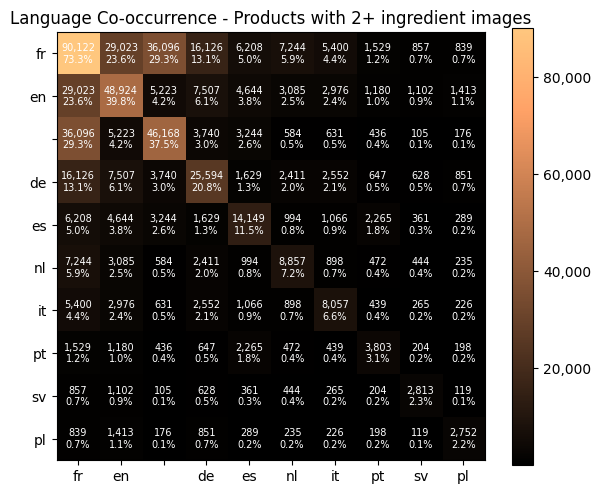

In [14]:
total = (df_images.images.map(len) > 1).sum()
max_count = 10
labels = order.str.replace('ingredients', '').str.replace('_', '')[:max_count]

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(co_occurrence.iloc[:max_count, :max_count], cmap='copper', interpolation='nearest')

# Show language labels on axes
plt.xticks(range(max_count), labels)
plt.yticks(range(max_count), labels)

plt.colorbar(im, ax=ax, format=FuncFormatter(lambda x, pos: f'{int(x):,}'))

annotate_matrix(ax, co_occurrence, max_count, max_count, total)

plt.title("Language Co-occurrence - Products with 2+ ingredient images")
plt.tight_layout()
plt.show()

## Known + Unknown Ingredients

In [15]:
print("Known:", "{:,}".format(df_images.known_ingredients_n.notna().sum()))
print("Unknown:", "{:,}".format(df_images.unknown_ingredients_n.notna().sum()))
print("Known+Unknown:", "{:,}".format((df_images.known_ingredients_n.notna() & df_images.unknown_ingredients_n.notna()).sum()))

df_identified = df_images[lambda x: x.known_ingredients_n.notna() & x.unknown_ingredients_n.notna()]
print("percentage products analyzed: {:.1f}%".format(len(df_identified) / len(df_images) * 100))

Known: 639,044
Unknown: 639,094
Known+Unknown: 639,044
percentage products analyzed: 62.3%


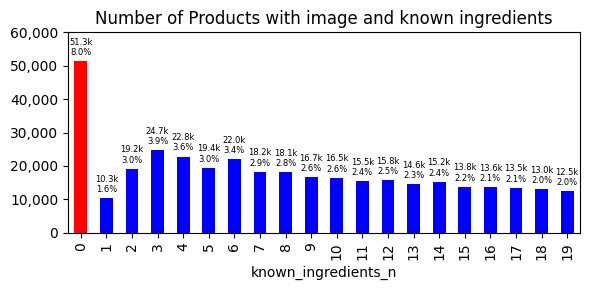

In [16]:
dfx = df_identified.known_ingredients_n.value_counts().sort_index()
colors = ['red' if idx == 0 else 'blue' for idx in dfx[:20].index]

ax = dfx[:20].plot.bar(figsize=(6,3), color=colors)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))

annotate_vbars(ax, len(df_identified))

ax.set_ylim(0, 60000)
plt.title("Number of Products with image and known ingredients")
plt.tight_layout();

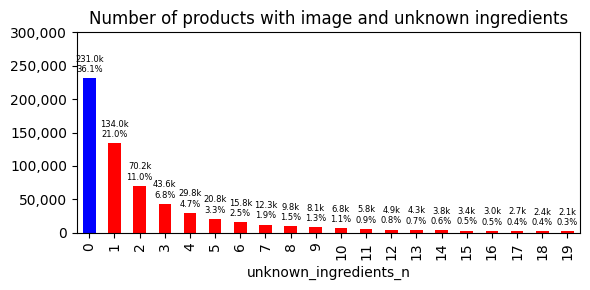

In [17]:
dfx = df_identified.unknown_ingredients_n.value_counts().sort_index()
dfx.index = pd.CategoricalIndex(dfx.index, ordered=True)
colors = ['blue' if idx == 0 else 'red' for idx in dfx[:20].index]

ax = dfx[:20].plot.bar(figsize=(6,3), color=colors)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))

annotate_vbars(ax, len(df_identified))

ax.set_ylim(0, 300000)
plt.title("Number of products with image and unknown ingredients")
plt.tight_layout();
plt.savefig("unknown_number_ingredients.png");

### Check Co-occurrence of Known and Unknown Ingredients

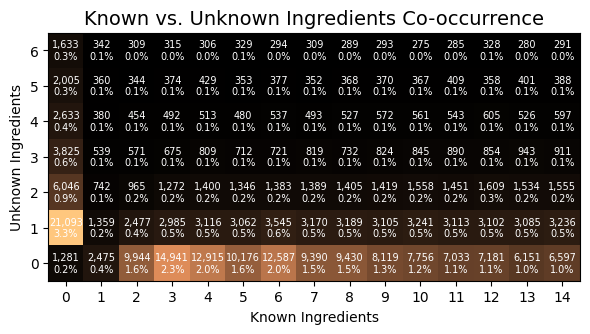

In [18]:
co_occurrence = pd.crosstab(
    df_identified.unknown_ingredients_n,
    df_identified.known_ingredients_n
)

max_x = 15
max_y = 7
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(co_occurrence.iloc[:max_y, :max_x], cmap='copper', interpolation='nearest')

# Show language labels on axes
plt.xticks(range(max_x), range(max_x))
plt.yticks(range(max_y), range(max_y))
plt.xlabel('Known Ingredients')
plt.ylabel('Unknown Ingredients')

ax.invert_yaxis()

annotate_matrix(ax, co_occurrence, max_x, max_y, len(df_identified))

plt.title("Known vs. Unknown Ingredients Co-occurrence", fontsize=14)
plt.tight_layout()
plt.show()

### Compute Known Ingredients Ratio

*known / (known + unknown)*

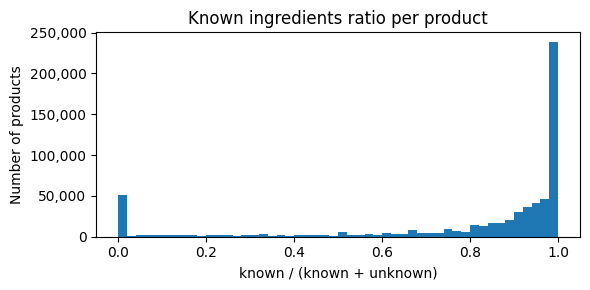

In [19]:
# vectorized version of the ratio function
def known_ratio(df: pd.DataFrame) -> pd.Series:
    known = df.known_ingredients_n
    unknown = df.unknown_ingredients_n
    total = known + unknown
    return known.div(total).where(total != 0, 0.0).where(total.notna(), pd.NA)

df_ratio = known_ratio(df_identified)

ax = df_ratio.plot.hist(bins=50, figsize=(6,3))

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))

plt.xlabel('known / (known + unknown)')
plt.ylabel('Number of products')
plt.title('Known ingredients ratio per product')
plt.tight_layout()
plt.show()

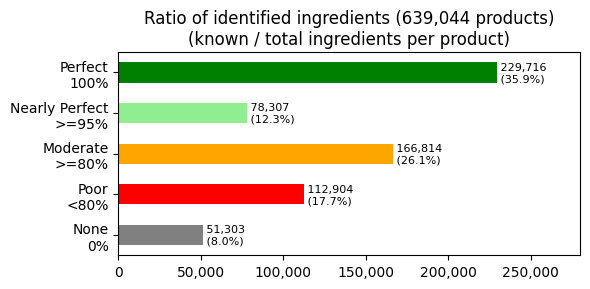

In [20]:
colors = ['green', 'lightgreen', 'orange', 'red', 'grey']
ratio_categories = ["100%", ">=95%", ">=80%", "<80%", "0%"]
labels = ['Perfect', 'Nearly Perfect', 'Moderate', 'Poor', 'None']

def categorize_ratio(ratio: float):
    if ratio is None or pd.isna(ratio):
        return "N/A"
    
    if ratio == 1:
        return ratio_categories[0]
    elif ratio >= 0.95:
        return ratio_categories[1]
    elif ratio >= 0.80:
        return ratio_categories[2]
    elif ratio == 0:
        return ratio_categories[4]
    else:
        return ratio_categories[3]

# Add the new column with the categories
s_cat_identified = df_ratio.map(categorize_ratio)
ax = s_cat_identified.value_counts().reindex(ratio_categories).plot.barh(figsize=(6,3), color=colors)

ax.yaxis.set_major_formatter(lambda x, pos: f"{labels[pos]}\n{ratio_categories[pos]}")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.invert_yaxis()
ax.set_xlim(0, 280000)

annotate_hbars(ax, len(df_identified))
    
plt.title(f"Ratio of identified ingredients ({len(df_identified):,} products)\n(known / total ingredients per product)")
plt.tight_layout()
plt.savefig("ratio_rating_ingredients.png");

## Analyze Ingredient Images Details

### Upload Time of Ingredient Images

Some images are missing `uploader` and `uploaded_t` -> the referenced `imgid` does not exist. (maybe deleted image?)

In [21]:
# Sanity check: any ingredient images with missing uploaded timestamp?
uploaded_na = df_images.images.map(lambda x: any([v['uploaded_t'] is None for v in x.values()]))
df_images[uploaded_na].images.map(lambda x: x.values())

code
0028435398622    ({'imgid': '2', 'uploader': None, 'uploaded_t'...
0051500042311    ({'imgid': '2', 'uploader': 'kiliweb', 'upload...
0055742509427    ({'imgid': '3', 'uploader': None, 'uploaded_t'...
00530361         ({'imgid': '5', 'uploader': None, 'uploaded_t'...
0068400021131    ({'imgid': '4', 'uploader': None, 'uploaded_t'...
                                       ...                        
5711657027467    ({'imgid': '3', 'uploader': None, 'uploaded_t'...
4316268707374    ({'imgid': '2', 'uploader': None, 'uploaded_t'...
7025110210968    ({'imgid': '3', 'uploader': None, 'uploaded_t'...
4061462867804    ({'imgid': '2', 'uploader': None, 'uploaded_t'...
4088700037270    ({'imgid': '3', 'uploader': None, 'uploaded_t'...
Name: images, Length: 792, dtype: object

### Investigate Upload Dates as Time Series

In [22]:
# remove images with missing uploaded timestamp (and convert any str to int)
s_uploaded_no_na = df_images.images.map(lambda x: [int(v['uploaded_t']) for v in x.values() if v['uploaded_t'] is not None])
# unnest the list of timestamps and convert to datetime
s_flat_uploaded = pd.to_datetime(s_uploaded_no_na.explode(), unit="s", errors="coerce")

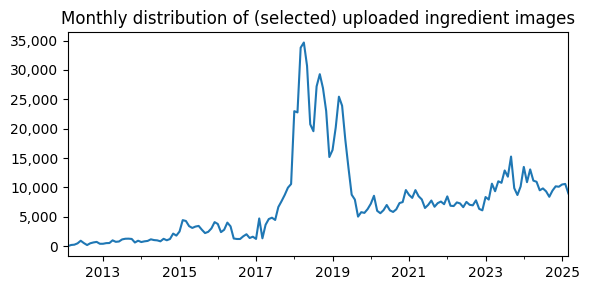

In [23]:
# aggregate by month
ax = s_flat_uploaded.dt.to_period('M').value_counts().sort_index().plot(figsize=(6,3))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))

plt.xlabel(None)
plt.title('Monthly distribution of (selected) uploaded ingredient images')
plt.tight_layout()
plt.show()

### Investigate uploaders

In [24]:
# remove images with missing uploader
s_flat_uploader = df_images.images.map(lambda x: [v['uploader'] for v in x.values() if v['uploader'] is not None]).explode()

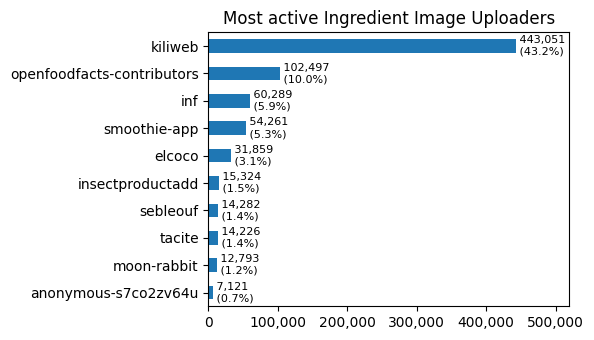

In [25]:
ax = s_flat_uploader.value_counts()[:10].plot.barh(figsize=(6,3.5))
ax.invert_yaxis()

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.set_ylabel(None)
ax.set_xlim(0, 520000)

annotate_hbars(ax, len(df_images))

plt.title('Most active Ingredient Image Uploaders')
plt.tight_layout()
plt.show()

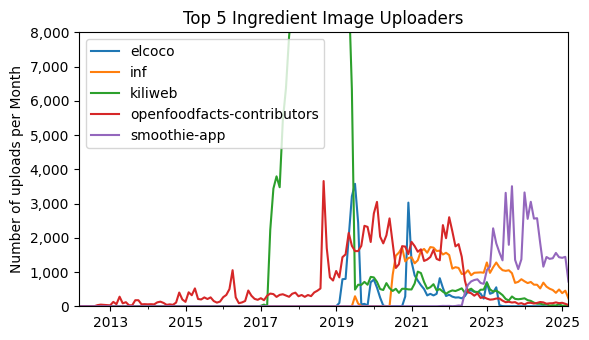

In [26]:
df_top_uploads = pd.concat([
  s_flat_uploader,
  s_flat_uploaded.dt.to_period('M'),
  ], keys=['uploader', 'uploaded_month'], axis=1
)[lambda x: x.uploader.isin(s_flat_uploader.value_counts().index[:5])]

ax = df_top_uploads.groupby(['uploaded_month', 'uploader']).size().unstack(fill_value=0).plot(figsize=(6,3.5))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))
ax.set_ylabel('Number of uploads per Month')
ax.set_xlabel(None)

plt.legend(title=None, loc='upper left')
plt.ylim(0, 8000)
plt.title('Top 5 Ingredient Image Uploaders')
plt.tight_layout()

### Count Uploads by Year

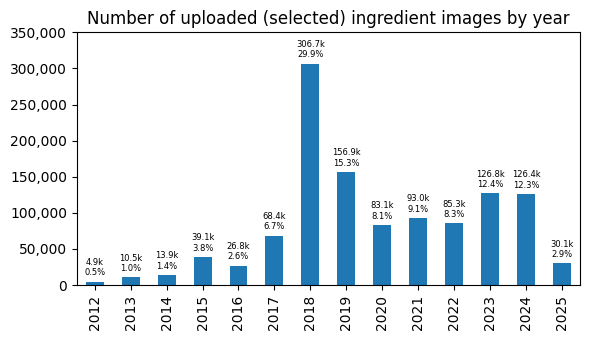

In [27]:
ax = s_flat_uploaded.dropna().dt.year.value_counts().sort_index().plot.bar(figsize=(6,3.5))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))

annotate_vbars(ax, len(df_images))
    
ax.set_ylim(0, 350000)
ax.set_xlabel(None)

plt.title("Number of uploaded (selected) ingredient images by year")
plt.tight_layout()

### Age of uploaded ingredient images (as of today)

In [28]:
# take only the latest ingredient image upload per product!
s_latest_upload = s_uploaded_no_na.map(lambda x: sorted(x)[-1] if len(x) != 0 else pd.NA).astype("Int64")
s_latest_upload = pd.to_datetime(s_latest_upload, unit="s", errors="coerce")

# relativedelta is more accurate than dividing by 365.25, but it's slower
#s_age_in_years = s_latest_upload.map(lambda x: relativedelta(pd.Timestamp.today(), x).years)

s_age_in_years = (pd.Timestamp.today() - s_latest_upload).dt.days.floordiv(365.25).astype("Int64")

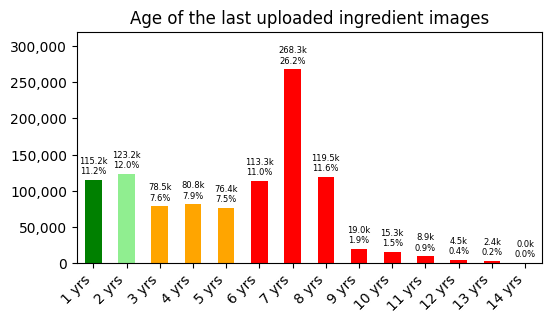

In [29]:
colors = ['green' if idx == 0 else 'lightgreen' if idx == 1 else 'orange' if idx<5 else 'red' for idx in dfx[:20].index]

ax = s_age_in_years.value_counts().sort_index().plot.bar(figsize=(6,3), color=colors)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)+1} yrs'))

ax.set_xlabel(None)
plt.xticks(rotation=45, ha='right')
plt.title("Age of the last uploaded ingredient images")
ax.set_ylim(0, 320000)

annotate_vbars(ax, len(s_age_in_years))

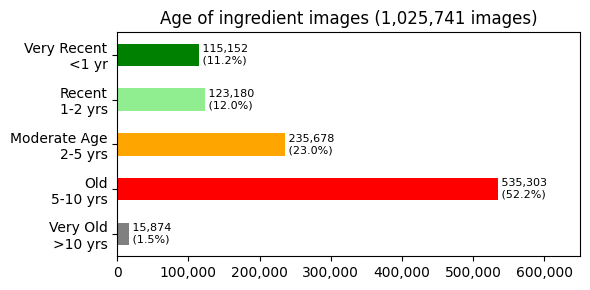

In [30]:
age_categories = ["<1 yr", "1-2 yrs", "2-5 yrs", "5-10 yrs", ">10 yrs"]
labels = ['Very Recent', 'Recent', 'Moderate Age', 'Old', 'Very Old']

def categorize_age(year: int):
    if year is None or pd.isna(year):
        return pd.NA

    if year == 0:
        return age_categories[0]
    elif year == 1:
        return age_categories[1]
    elif year < 5:
        return age_categories[2]
    elif year < 10:
        return age_categories[3]
    else:
        return age_categories[4]

colors = ['green', 'lightgreen', 'orange', 'red', 'grey']

ax = s_age_in_years.map(categorize_age).value_counts().reindex(age_categories).plot.barh(figsize=(6,3), color=colors)

ax.yaxis.set_major_formatter(lambda x, pos: f"{labels[pos]}\n{age_categories[pos]}")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.invert_yaxis()
ax.set_xlim(0, 650000)
ax.set_ylabel(None)

annotate_hbars(ax, len(s_age_in_years))

plt.title(f"Age of ingredient images ({len(s_age_in_years):,} images)")
plt.tight_layout()
plt.savefig("age_of_images_rating.png");

### Investigate Combination of Image Age and Known Ingredients Ratio

In [31]:
df_cross = pd.crosstab(
  s_age_in_years.map(categorize_age).fillna("Missing"),
  known_ratio(df_images).map(categorize_ratio),
).reindex(index=[*age_categories, "Missing"], columns=[*ratio_categories, 'N/A'])

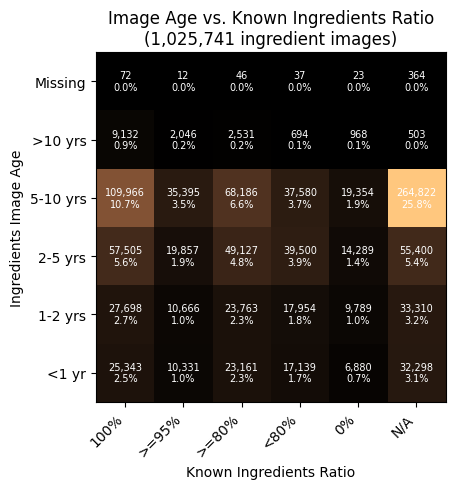

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(df_cross, cmap='copper', interpolation='nearest')
ax.invert_yaxis()

# Set ticks based on the DataFrame dimensions
ax.set_xticks(np.arange(df_cross.shape[1]))
ax.set_yticks(np.arange(df_cross.shape[0]))

# Set tick labels to the DataFrame's column names and index values
ax.set_xticklabels(df_cross.columns, rotation=45, ha='right')
ax.set_yticklabels(df_cross.index)

annotate_matrix(ax, df_cross, 6, 6, len(df_images))

ax.set_xlabel("Known Ingredients Ratio")
ax.set_ylabel("Ingredients Image Age")

plt.title(f"Image Age vs. Known Ingredients Ratio\n({len(df_images):,} ingredient images)")
plt.tight_layout()
plt.show()

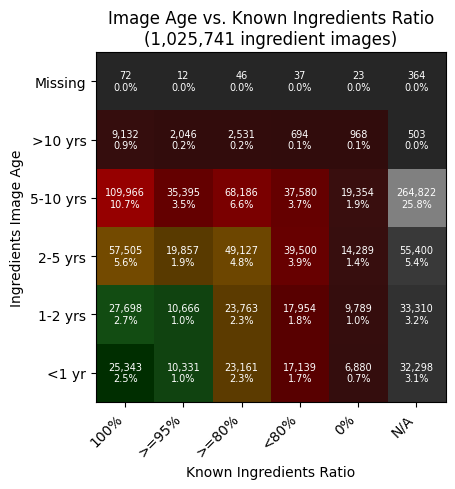

In [33]:
nrows, ncols = df_cross.shape
values = df_cross.values

# Build an array of RGBA colors using a nested list comprehension.
vmin = np.nanmin(values)
vmax = np.nanmax(values)
rgba_colors = np.array([
    [ mcolors.to_rgba(get_cell_color(i, j, values[i, j], vmin, vmax)) for j in range(ncols) ]
    for i in range(nrows)
])

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(rgba_colors, interpolation="nearest")
ax.invert_yaxis()

annotate_matrix(ax, df_cross, 6, 6, len(df_images))

# Set ticks and labels.
ax.set_xticks(np.arange(ncols))
ax.set_yticks(np.arange(nrows))
ax.set_xticklabels(df_cross.columns, rotation=45, ha='right')
ax.set_yticklabels(df_cross.index)
ax.set_xlabel("Known Ingredients Ratio")
ax.set_ylabel("Ingredients Image Age")

plt.title(f"Image Age vs. Known Ingredients Ratio\n({len(df_images):,} ingredient images)")
plt.tight_layout()
plt.show()

## Ingredient Percent Analysis (WIP)

In [34]:
df_analysis = df_images[lambda x: x.ingredients_percent_analysis.notna()]
print(f"{len(df_analysis):,}")
df_analysis.ingredients_percent_analysis.value_counts()#  / len(df_images) * 100

639,133


ingredients_percent_analysis
1     568873
-1     70260
Name: count, dtype: Int64

In [35]:
df_images.quality_info.str.contains('en:ingredients-percent-analysis-ok').sum()

568282

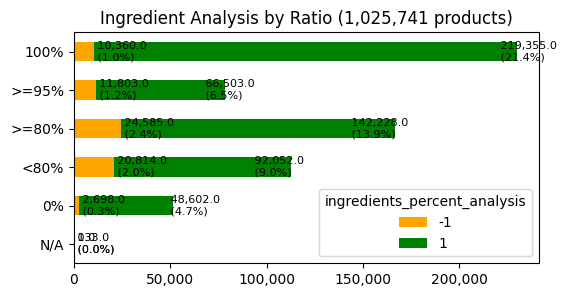

In [36]:
df_ratio_cross = pd.crosstab(
  known_ratio(df_images).map(categorize_ratio),
  df_images.ingredients_percent_analysis
).reindex(index=[*ratio_categories, "N/A"])

ax = df_ratio_cross.plot.barh(stacked=True, figsize=(6, 3), color=['orange', 'green'])
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.invert_yaxis()
ax.set_ylabel(None)

annotate_hbars(ax, len(df_images))

plt.title(f"Ingredient Analysis by Ratio ({len(df_images):,} products)");

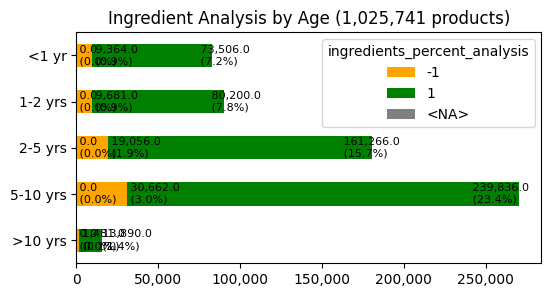

In [37]:

df_age_cross = pd.crosstab(
  s_age_in_years.map(categorize_age),
  df_images.ingredients_percent_analysis
).reindex(index=[*age_categories], columns=[-1, 1, pd.NA])

ax = df_age_cross.plot.barh(stacked=True, figsize=(6, 3), color=['orange', 'green', 'grey'])
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.invert_yaxis()
ax.set_ylabel(None)

annotate_hbars(ax, len(df_images))

plt.title(f"Ingredient Analysis by Age ({len(df_images):,} products)");